In [2]:
import pandas as pd
import numpy as np
import os
import nltools as nlt
import nilearn as nil
import nibabel as nib
import warnings
import glob
import random
import pickle
import gc #garbage collection



/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [19]:
from nilearn.plotting import plot_glass_brain
from nilearn.masking import compute_brain_mask


This file based on `whole_series_filtered`.

The aim here is that we will analyze exactly one TR, the one that starts between 0 and 2 seconds after the pre-selection phase begins. I hope that we will be able to identify useful data and that we can use this method to avoid a finger press.
 

### Load brain data

In [3]:
pd.set_option('display.max_rows', 99)

In [7]:
with open('../data/Brain_Data_raw_60subs.pkl', 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)
    
brain_data_subs=Brain_Data_allsubs.X.subject.unique()

test_train_set = pd.read_csv("../data/train_test_markers_20210601T183243.csv")

holdout_subs_set = set(test_train_set[test_train_set.SplitGroup=="Holdout"].sub_label)
train_subs_set = set(test_train_set[test_train_set.SplitGroup=="Train"].sub_label)
holdout_data_intersection = holdout_subs_set.intersection(brain_data_subs)
train_data_intersection = train_subs_set.intersection(brain_data_subs)

if len(holdout_data_intersection)>0:
    del Brain_Data_allsubs
    raise Exception("The brain data contains a subject marked for holdout. Do not process!")
else:
    print("checked for intersection and no intersection between the brain data and the subjects was found.")
    if len(train_data_intersection)==0:
        del Brain_Data_allsubs
        raise Exception("the brain data doesn't contain any of the train data. something is wrong.")
    else:
        print("there were " + str(len(train_data_intersection)) + " subjects overlapping between the subjects marked for train data and the training dump file itself.")

    

checked for intersection and no intersection between the brain data and the subjects was found.
there were 60 subjects overlapping between the subjects marked for train data and the training dump file itself.


run4    960
run3    944
run2    944
run1    944
Name: run, dtype: int64

Good! No intersection

## CV

In [8]:
Brain_Data_allsubs.X.response.value_counts()

5.0    1149
6.0    1007
7.0     896
8.0     599
Name: response, dtype: int64

A final word for today: can we predict the WTP choice? Now, remember that this data is likely conflated by keypress, so...there's that to be concerned about.

In [9]:
Brain_Data_allsubs.Y = Brain_Data_allsubs.X.response.copy()

In [10]:
Brain_Data_allsubs.Y.value_counts()

5.0    1149
6.0    1007
7.0     896
8.0     599
Name: response, dtype: int64

In [11]:
Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None

to do this we need to remove the null-response items.

In [12]:
Brain_Data_allsubs.Y.value_counts()

5.0    1149
6.0    1007
7.0     896
8.0     599
Name: response, dtype: int64

In [13]:
Brain_Data_allsubs.Y.isnull().value_counts()

False    3651
True      141
Name: response, dtype: int64

In [14]:
Brain_Data_allsubs_nn = Brain_Data_allsubs[Brain_Data_allsubs.Y.isnull()==False]

In [15]:
print(len(Brain_Data_allsubs_nn))
print(len(Brain_Data_allsubs))

3651
3792


In [16]:
Brain_Data_allsubs_nn.Y=Brain_Data_allsubs_nn.Y.astype(int)

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 8.22
overall CV Correlation: -0.01


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


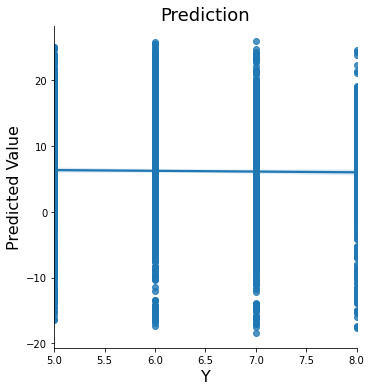

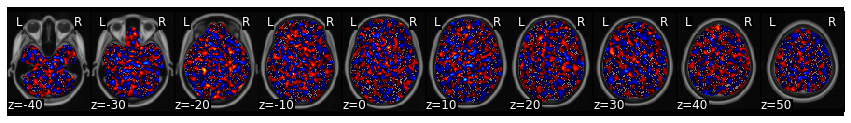

In [17]:
prediction_across_subjects = Brain_Data_allsubs_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_nn.X.subject})

#print(prediction_across_subjects)


How could we improve here?

 - We could try to enhance prediction more by improving the algorithm but for now this is not a great sign for generalizability. 
 - When learning on 48 subjects at a time and holding out 12, we seem to overfit to the 48! Perhaps there's some ML we can do to reduce overfitting; perhaps taking averages within subjects or other sort of regularization approach might actually be helpful.
 - Alternatively, this data is not pre-processed; no high-pass filter; it's very raw. Perhaps there's a middle ground (e.g., at least high-pass filtering) that might help us get better data.
 - I think we only have the first run here? Maybe? 

As a sanity check it might be a good idea to do a raw extraction of the finger-press moment. That would help me to understand how much work the pre-processing is doing.

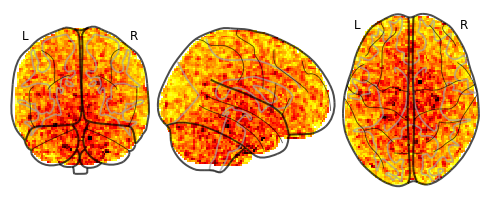

In [20]:
plot_glass_brain(prediction_across_subjects['weight_map'].to_nifti())

### Extract fingerpress data

In [29]:
with open('../data/Brain_Data_raw_fingerpress_60subjs.pkl', 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)
    
brain_data_subs=Brain_Data_allsubs.X.subject.unique()

test_train_set = pd.read_csv("../data/train_test_markers_20210601T183243.csv")

holdout_subs_set = set(test_train_set[test_train_set.SplitGroup=="Holdout"].sub_label)
train_subs_set = set(test_train_set[test_train_set.SplitGroup=="Train"].sub_label)
holdout_data_intersection = holdout_subs_set.intersection(brain_data_subs)
train_data_intersection = train_subs_set.intersection(brain_data_subs)

if len(holdout_data_intersection)>0:
    del Brain_Data_allsubs
    raise Exception("The brain data contains a subject marked for holdout. Do not process!")
else:
    print("checked for intersection and no intersection between the brain data and the holdout subjects was found.")
    if len(train_data_intersection)==0:
        del Brain_Data_allsubs
        raise Exception("the brain data doesn't contain any of the train data. something is wrong.")
    else:
        print("there were " + str(len(train_data_intersection)) + " subjects overlapping between the subjects marked for train data and the training dump file itself.")

    

checked for intersection and no intersection between the brain data and the subjects was found.
there were 60 subjects overlapping between the subjects marked for train data and the training dump file itself.


In [30]:
Brain_Data_allsubs.X.response.value_counts()
Brain_Data_allsubs.Y = Brain_Data_allsubs.X.response.copy()
Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None
Brain_Data_allsubs_nn = Brain_Data_allsubs[Brain_Data_allsubs.Y.isnull()==False]
print(len(Brain_Data_allsubs_nn))
print(len(Brain_Data_allsubs))

3651
3651


In [31]:
Brain_Data_allsubs_nn.Y=Brain_Data_allsubs_nn.Y.astype(int)

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 7.27
overall CV Correlation: 0.05


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


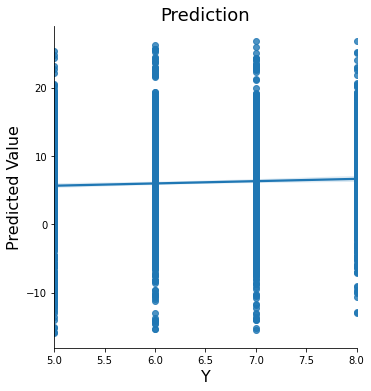

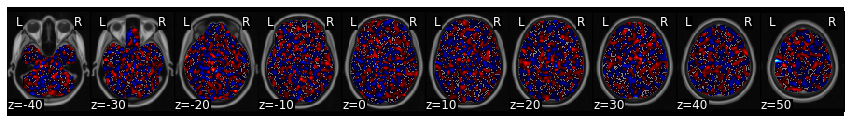

In [32]:
prediction_across_subjects = Brain_Data_allsubs_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_nn.X.subject})

#print(prediction_across_subjects)


If the raw fingerpress data was predictive, that would suggest that the lack of predictivity above (with the raw pre-decision phase) is primarily attributable to the lack of indicative data in that phase.

However, that's not what we find. Instead, even data extracted at the time of the fingerpress is not really predictive. Interestingly, there is one bright spot and it _is_ in the finger region of the brain.

It's possible this could be further improved if we applied a crude HRF: rather than convolving with a double sine wave, we just take the image 6 seconds on from where we started. Let's try that....

If it works, then we learn two more things:

1. Grabbing data at the very beginning of a signal rather than applying the HRF really doesn't give you much signal.
2. And we'll have confirmed that the raw fingerpress data is predictive, meaning that raw data in this case is of value if you get the right raw data.

### fingerpress data with crude HRF

a crude HRF was applied just by extracting hte first image _five seconds after_ the onset of the target event.

In [33]:
with open('../data/Brain_Data_raw_fingerpress_crudehrf_60subs.pkl', 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)
    
brain_data_subs=Brain_Data_allsubs.X.subject.unique()

test_train_set = pd.read_csv("../data/train_test_markers_20210601T183243.csv")

holdout_subs_set = set(test_train_set[test_train_set.SplitGroup=="Holdout"].sub_label)
train_subs_set = set(test_train_set[test_train_set.SplitGroup=="Train"].sub_label)
holdout_data_intersection = holdout_subs_set.intersection(brain_data_subs)
train_data_intersection = train_subs_set.intersection(brain_data_subs)

if len(holdout_data_intersection)>0:
    del Brain_Data_allsubs
    raise Exception("The brain data contains a subject marked for holdout. Do not process!")
else:
    print("checked for intersection and no intersection between the brain data and the holdout subjects was found.")
    if len(train_data_intersection)==0:
        del Brain_Data_allsubs
        raise Exception("the brain data doesn't contain any of the train data. something is wrong.")
    else:
        print("there were " + str(len(train_data_intersection)) + " subjects overlapping between the subjects marked for train data and the training dump file itself.")

    

checked for intersection and no intersection between the brain data and the holdout subjects was found.
there were 60 subjects overlapping between the subjects marked for train data and the training dump file itself.


In [34]:
Brain_Data_allsubs.X.response.value_counts()
Brain_Data_allsubs.Y = Brain_Data_allsubs.X.response.copy()
Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None
Brain_Data_allsubs_nn = Brain_Data_allsubs[Brain_Data_allsubs.Y.isnull()==False]
print(len(Brain_Data_allsubs_nn))
print(len(Brain_Data_allsubs))

3636
3636


In [35]:
Brain_Data_allsubs_nn.Y=Brain_Data_allsubs_nn.Y.astype(int)

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 7.77
overall CV Correlation: 0.06


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


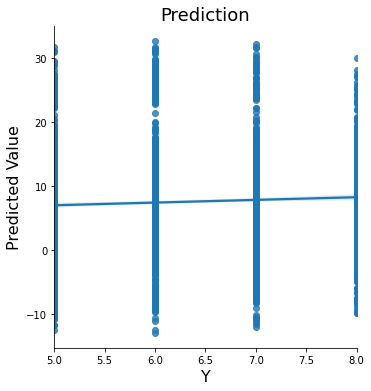

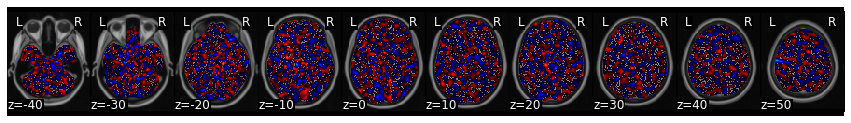

In [36]:
prediction_across_subjects = Brain_Data_allsubs_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_nn.X.subject})

#print(prediction_across_subjects)


In [47]:
print(prediction_across_subjects['r_xval'])

0.059053154906699185


OK. that didn't really meaningfully improve the result. going through the proper SPM process clearly improves the process substantially, whicih implies that--if possible--we should use it.

Let's just see though whether this is still better than chance.

In [58]:
import random
random.seed()

In [60]:
for i in range(10):
    y_vals = Brain_Data_allsubs_nn.Y
    random.shuffle(y_vals)
    Brain_Data_allsubs_nn.Y= y_vals
    prediction_across_subjects = Brain_Data_allsubs_nn.predict(algorithm='ridge',
                               cv_dict = {'type':'kfolds',
                                          'n_folds':5,
                                          'subject_id':Brain_Data_allsubs_nn.X.subject},
                                                              plot=False)
    rand_1_crossvalscore = prediction_across_subjects['r_xval']
    print("overall CV correlation: " + str(rand_1_crossvalscore))


overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 8.58
overall CV Correlation: -0.01
overall CV correlation: -0.010153969141242235
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 7.89
overall CV Correlation: 0.02
overall CV correlation: 0.022419685725570463
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 8.25
overall CV Correlation: -0.01
overall CV correlation: -0.014253947943688353
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 8.56
overall CV Correlation: -0.01
overall CV correlation: -0.006899547375328573
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 8.78
overall CV Correlation: 0.00
overall CV correlation: 0.0010413577552468196
overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error

In [62]:
import numpy as np
import scipy.stats as st

def get_t_interval(data):
    return(st.t.interval(alpha=0.95,df=len(data)-1, loc=np.mean(data),scale=st.sem(data)))

In [63]:
get_t_interval([-0.01,0.022,-0.014,-0.007,0.001,0.023,-0.01,-0.001])

(-0.011565543445122275, 0.012565543445122276)

OK, there is clearly SOME predictive power in the raw data. It isn't clear that the crude HRF helped. But it is clear that the fingerpress data has predictive power (around r=0.05) whereas the original data does not.

So the next thing that we do is try to 